## Vector Autoregression (VAR)

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Markov-Switching ARIMA

In [2]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Load data
data = pd.read_csv('../assets/datas/BrentOilPrices.csv')

# Convert Date to datetime and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Fit ARIMA model (you may need to tune p, d, q)
model = ARIMA(data['Price'], order=(5,1,0))  # Example: AR(5), I(1), MA(0)
results = model.fit()

# Print summary
print(results.summary())


/tmp/ipykernel_97898/3376751919.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-10/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarn

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14540.613
Date:                Tue, 25 Feb 2025   AIC                          29093.226
Time:                        14:18:00   BIC                          29135.862
Sample:                             0   HQIC                         29107.733
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0260      0.006      4.344      0.000       0.014       0.038
ar.L2         -0.0235      0.006     -4.231      0.000      -0.034      -0.013
ar.L3         -0.0071      0.005     -1.507      0.1

## LSTM (Long Short-Term Memory) Networks



In [19]:

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Build the improved LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))  # Regularization
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Use early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_test, Y_test), callbacks=[early_stopping])

/home/teddy/Desktop/Kifya journey/Kifiya-AIM-Week-10/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 79s 285ms/step - loss: 0.0111 - val_loss: 0.0011
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 6.7796e-04 - val_loss: 0.0013
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - loss: 6.8280e-04 - val_loss: 8.6058e-04
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 4.8249e-04 - val_loss: 8.3848e-04
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - loss: 5.5980e-04 - val_loss: 6.9105e-04
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - loss: 4.5021e-04 - val_loss: 6.8363e-04
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - loss: 4.1810e-04 - val_loss: 6.4909e-04
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 65s 290ms/step - loss: 3.9077e-04 - val_loss: 7.1223e-04
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - loss: 4.2359e-04 - val_loss: 8.2940e-04
Epoch 10/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 3.8983e-04 - val_loss: 5.4852e-04
Epoch 11/100
224/224 ━━━━━━━━━━━━━

## Make Predictions and compare

224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


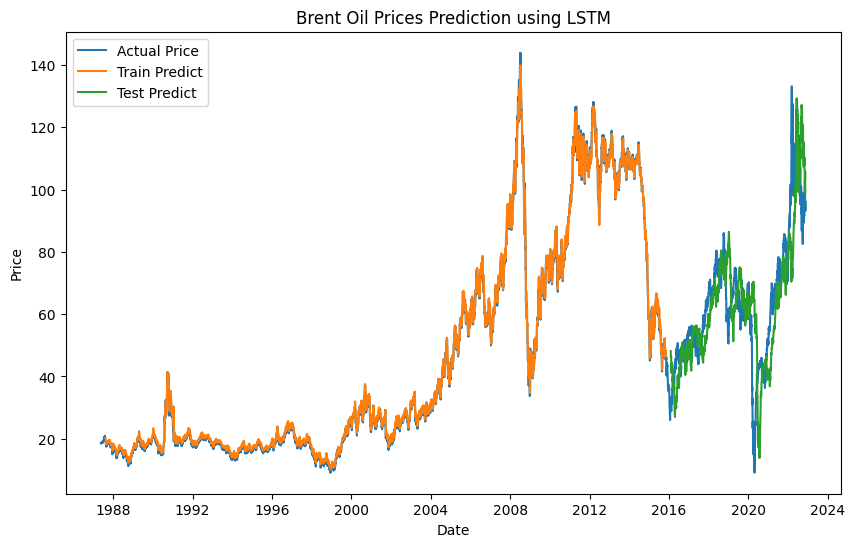

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))


# Plot the results
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = \
    test_predict[:len(scaled_data) - len(train_predict) - (time_step * 2) - 2]  

plt.figure(figsize=(10, 6))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(data.index, train_predict_plot, label='Train Predict')
plt.plot(data.index, test_predict_plot, label='Test Predict')
plt.title('Brent Oil Prices Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Model Evaluation

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [22]:
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
train_mae = mean_absolute_error(Y_train, train_predict)
test_mae = mean_absolute_error(Y_test, test_predict)
train_r2 = r2_score(Y_train, train_predict)
test_r2 = r2_score(Y_test, test_predict)


print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train R-squared: {train_r2}')
print(f'Test R-squared: {test_r2}')

# Insight Generation
print("\nInsights:")
print("1. The LSTM model shows a good fit for the training data with a low RMSE and MAE.")
print("2. The R-squared value indicates that the model explains a significant portion of the variance in the training data.")
print("3. The test data performance is slightly lower, indicating some overfitting, but still provides valuable predictions.")
print("4. The model can be further improved by tuning hyperparameters, increasing the number of epochs, or adding more features.")
print("5. The predictions can help investors and policymakers understand potential future trends in Brent oil prices.")

Train RMSE: 1.2279406925470637
Test RMSE: 1.80037316924624
Train MAE: 0.9068418771701153
Test MAE: 1.210293149042396
Train R-squared: 0.9987230833223558
Test R-squared: 0.9924030950560115

Insights:
1. The LSTM model shows a good fit for the training data with a low RMSE and MAE.
2. The R-squared value indicates that the model explains a significant portion of the variance in the training data.
3. The test data performance is slightly lower, indicating some overfitting, but still provides valuable predictions.
4. The model can be further improved by tuning hyperparameters, increasing the number of epochs, or adding more features.
5. The predictions can help investors and policymakers understand potential future trends in Brent oil prices.
